### Braided demo overview

Anchors:
- `analog_image_generator.geologic_generators.generate_braided`
- `analog_image_generator.stacked_channels.build_stacked_fluvial`
- `analog_image_generator.stats.compute_metrics`
- `analog_image_generator.reporting.build_reports`

Use this notebook to demonstrate the features listed below. Fill in the upcoming sections (presets, generator runs, stacked packages, metrics, reporting, and debugging hooks) before the professor review.


# Fluvial Braided Anchors
Traceability stubs for braided helpers referenced in GEOLOGIC_RULES.md.


#### Demo checklist

- [ ] Parameter presets for threads/bars/chutes
- [ ] Single-belt braided generator run
- [ ] Stacked package mix (braided + meandering) demo
- [ ] Visualization (gray/channel/bar/chute overlays + legend)
- [ ] Metrics + QA summary
- [ ] Reporting/artifact link
- [ ] Debug sliders/seeds


In [1]:
from analog_image_generator import geologic_generators as gg

BRAIDED_BASELINE = {
    "style": "braided",
    "height": 256,
    "width": 256,
    "seed": 101,
    "thread_count": gg._BRAIDED_DEFAULTS["thread_count"],
    "mean_thread_width": gg._BRAIDED_DEFAULTS["mean_thread_width"],
    "bar_spacing_factor": gg._BRAIDED_DEFAULTS["bar_spacing_factor"],
    "chute_frequency": gg._BRAIDED_DEFAULTS["chute_frequency"],
}

BRAIDED_WIDE_CHANNELS = {
    **BRAIDED_BASELINE,
    "mean_thread_width": 26.0,
    "thread_count": 7,
}

BRAIDED_STACKED_BELT = {
    **BRAIDED_BASELINE,
    "mode": "stacked",
    "package_count": 3,
    "package_styles": ["braided", "meandering", "braided"],
    "package_relief_px": 22,
    "package_erosion_depth_px": 14,
}

BRAIDED_PRESETS = {
    "baseline": BRAIDED_BASELINE,
    "wide_channels": BRAIDED_WIDE_CHANNELS,
    "stacked_belt": BRAIDED_STACKED_BELT,
}
BRAIDED_PRESETS

{'baseline': {'style': 'braided',
  'height': 256,
  'width': 256,
  'seed': 101,
  'thread_count': 5,
  'mean_thread_width': 18.0,
  'bar_spacing_factor': 4.2,
  'chute_frequency': 0.35},
 'wide_channels': {'style': 'braided',
  'height': 256,
  'width': 256,
  'seed': 101,
  'thread_count': 7,
  'mean_thread_width': 26.0,
  'bar_spacing_factor': 4.2,
  'chute_frequency': 0.35},
 'stacked_belt': {'style': 'braided',
  'height': 256,
  'width': 256,
  'seed': 101,
  'thread_count': 5,
  'mean_thread_width': 18.0,
  'bar_spacing_factor': 4.2,
  'chute_frequency': 0.35,
  'mode': 'stacked',
  'package_count': 3,
  'package_styles': ['braided', 'meandering', 'braided'],
  'package_relief_px': 22,
  'package_erosion_depth_px': 14}}

In [2]:
from analog_image_generator import geologic_generators as gg
from analog_image_generator import stacked_channels as sc

def run_single_braided(params: dict) -> tuple:
    config = {**BRAIDED_PRESETS['baseline'], **params}
    return gg.generate_fluvial(config)

def run_stacked_braided(params: dict) -> tuple:
    config = {**BRAIDED_PRESETS['stacked_belt'], **params}
    return sc.build_stacked_fluvial(config)

single_braided = run_single_braided({})
stacked_braided = run_stacked_braided({})
single_braided[0].shape, stacked_braided[0].shape

((256, 256), (256, 256))

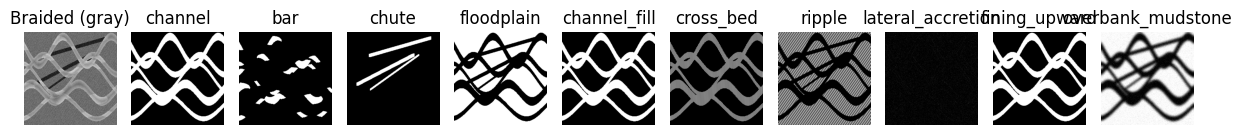

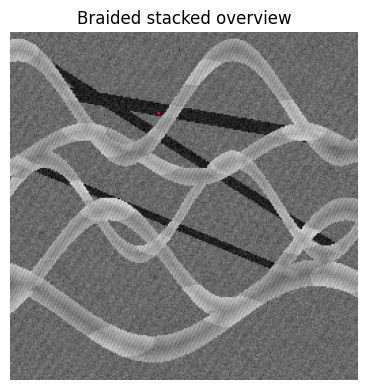

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def _mask_arrays(masks_dict):
    arrays = []
    for name, value in masks_dict.items():
        if isinstance(value, np.ndarray) and value.ndim >= 2:
            arrays.append((name, value.astype(np.float32)))
    return arrays

def _plot_masks(analog, masks_dict, title: str):
    arrays = _mask_arrays(masks_dict)
    fig, axes = plt.subplots(1, len(arrays) + 1, figsize=(12, 4))
    axes[0].imshow(analog, cmap='gray', vmin=0.0, vmax=1.0)
    axes[0].set_title(f"Braided (gray)")
    axes[0].axis('off')
    for ax, (name, mask) in zip(axes[1:], arrays):
        ax.imshow(mask, cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(name)
        ax.axis('off')
    fig.tight_layout()

analog_single, masks_single = single_braided
_plot_masks(analog_single, masks_single, 'Braided single run')

analog_stacked, masks_stacked = stacked_braided
fig = plt.figure(figsize=(6, 4))
plt.imshow(analog_stacked, cmap='gray', vmin=0.0, vmax=1.0)
package_map = masks_stacked.get('package_id_map')
if isinstance(package_map, np.ndarray) and package_map.ndim >= 2:
    plt.contour(package_map, levels=6, colors='r', linewidths=0.4)
plt.title('Braided stacked overview')
plt.axis('off')
fig.tight_layout()

## anchor-fluvial-braided-threads
`braided_threads(H, W, thread_count, mean_width, rng)` creates multiple channel threads.

## anchor-fluvial-bar-spacing
`seed_bars(thread_masks, metadata, bar_spacing_factor, rng, shape)` enforces PRD bar spacing.

## anchor-fluvial-chutes
`add_chutes(centerlines, metadata, chute_frequency, rng, shape)` lays out chute masks.

## anchor-fluvial-braided-compose
`compose_braided(gray, masks, noise_scale, rng)` normalizes braided grayscale + masks.

## anchor-fluvial-braided-generate
`generate_braided(params, rng)` orchestrates threads, bars, chutes, and floodplain composition.

## anchor-sedimentary-approximations
Sedimentary overlays in this notebook use simplified distance-to-mask gradients, Gaussian-smoothed noise, and deterministic laminae frequencies (no fully resolved laminae or grain-scale physics). Mineralogy percentages are constrained heuristics (`feldspar`, `quartz`, `clay`) summing to 1.0; cement signatures toggle between kaolinite/calcite based on marsh coverage, and mud_clasts_bool reflects overbank fraction. These approximations target qualitative realism for previews/statistics rather than exact petrophysical fidelity.


### anchor-fluvial-stack-sequence

`analog_image_generator.stacked_channels.sequence_packages` loops over package specs, dispatches to the braided/meandering/anasto generators, and accumulates masks + metadata per package before emitting the stacked 3D gray cube. 
The sequence ensures deterministic seeds via `stack_seed`, records package IDs, and unions mask suites so stats/reporting can trace each stacked belt.

### anchor-fluvial-bar-spacing

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-braided-compose

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-braided-generate

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-braided-threads

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-chutes

Automated anchor placeholder for GEOLOGIC_RULES mapping.